# Step 1: Getting the Article and Population Data
The first step is getting the data, which lives in several different places. You will need data that lists Wikipedia articles of politicians and data for country populations.
The Wikipedia Category:Politicians by nationality was crawled to generate a list of Wikipedia article pages about politicians from a wide range of countries. This data is in the homework folder as politicians_by_country.SEPT.2022.csv.
The population data is available in CSV format as population_by_country_2022.csv from the homework folder. This dataset is drawn from the world population data sheet published by the Population Reference Bureau.


## Step 1a - Read the population and politicians input data files

Load the below two workbooks:
1. population data (population_by_country_2022.csv) - Consists of countries, region and population for each country/region
2. Politicians data (politicians_by_country.SEPT.2022.csv) - Consists of crawled Wikipedia article pages about politicians fropm wide range of countries

### Import the required packages

Importing the packages for extraction, transformation, plotting the data

In [1]:
# These are standard python modules
import json, time, urllib.parse
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
from datetime import datetime

### Read the input data files

In [2]:
df_politicians = pd.read_csv('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/input/politicians_by_country_SEPT.2022.csv')
df_population = pd.read_csv('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/input/population_by_country_2022.csv')
df_politicians.head()

,name,url,country
0,Shahjahan Noori,https://en.wikipedia.org/wiki/Shahjahan_Noori,Afghanistan
1,Abdul Ghafar Lakanwal,https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...,Afghanistan
2,Majah Ha Adrif,https://en.wikipedia.org/wiki/Majah_Ha_Adrif,Afghanistan
3,Haroon al-Afghani,https://en.wikipedia.org/wiki/Haroon_al-Afghani,Afghanistan
4,Tayyab Agha,https://en.wikipedia.org/wiki/Tayyab_Agha,Afghanistan


## Step 1b - Highlight the Considerations and Data Inconsistencies
You should be a little careful with the data. Crawling Wikipedia categories to identify relevant page subsets can result in misleading and/or duplicate category labels. Naturally, the data crawl attempted to resolve these, but not all may have been caught. You should document how you handle any data inconsistencies.
The population_by_country_2022.csv contains some rows that provide cumulative regional population counts. These rows are distinguished by having ALL CAPS values in the 'geography' field (e.g. AFRICA, OCEANIA). These rows won't match the country values in politicians_by_country.SEPT.2022.csv, but you will want to retain some of them so that you can report coverage and quality by region as specified in the analysis section below.


### Data Inconsistencies

There are few duplicates in the politicians input data file. I removed only absolute duplicates in the data and took forward the duplicates at article name level. 

In [3]:
# Obtain the records where there are duplicates at the article level
duplicate_articles = df_politicians[df_politicians.duplicated(subset=['name', 'url'], keep = False)]
# Obtain the records where there are absolute duplicates (all fields)
duplicate_records = df_politicians[df_politicians.duplicated(subset=['name', 'url', 'country'], keep = False)]
# Print these duplicate records count
print(f'''There are a total of {duplicate_articles.shape[0]} duplicate articles with different country names''')
print(f'''There are a total of {duplicate_records.shape[0]} duplicate records with same name, url and country names''')

There are a total of 98 duplicate articles with different country names
There are a total of 4 duplicate records with same name, url and country names


### Removing the duplicate record

Obtaining the recent/last updated record from the provided workbook and removing the duplicates

In [4]:
# Exclude the absolute duplicate records
df_politicians = df_politicians[~df_politicians.duplicated(subset=['name', 'url', 'country'], keep = 'last')]
df_politicians.shape

(7582, 3)

### Population value being 0 for few countries

There are few countries where the population is mentioned as 0. This can be because the value is in millions and is rounded to the nearest decimal.

**Note:** I filtered for these countries at Step 4 where we calculate the article-per-capita as they give infinity values because of 0 in the denominator 

In [5]:
# Filter for regions with zero population
zero_population = df_population[df_population['Population (millions)'] == 0]
print(f'''There are a total of {zero_population.shape[0]} countries with population as zero''')
zero_population.head()

There are a total of 6 countries with population as zero


,Geography,Population (millions)
183,Liechtenstein,0.0
185,Monaco,0.0
211,San Marino,0.0
223,Nauru,0.0
226,Palau,0.0


### Considerations

Eliminating the cumulative regional population counts and obtaining the closest/lowest in the hierarchy regions for the countries

In [6]:
df_population['shifted'] = df_population['Geography'].shift(-1)
df_population = df_population[~((df_population['Geography'].str.isupper() == True) & (df_population['shifted'].str.isupper() == True))].iloc[:,0:2].reset_index().drop('index', axis = 1)
# Obtain the regions which are capital case in the data
regions = pd.DataFrame()
regions['region'] = df_population[df_population['Geography'].str.isupper()]['Geography']
regions['flag'] = np.arange(1, len(regions['region']) + 1)
# Obtain the country and region linkage
df = df_population.merge(regions, left_on = "Geography", right_on = "region", how = 'left').iloc[:,[0,1,3]]
# Fill the region column for linkage region to be populated
df['flag'] = df['flag'].expanding().max()
df_population = df.merge(regions, on = "flag", how = 'inner')
df_population = df_population.iloc[:,[0, 1, 3]]
# Filter for only countries in the geography column
df_population = df_population[df_population['Geography'] != df_population['region']]
df_population.head()

,Geography,Population (millions),region
1,Algeria,44.9,NORTHERN AFRICA
2,Egypt,103.5,NORTHERN AFRICA
3,Libya,6.8,NORTHERN AFRICA
4,Morocco,36.7,NORTHERN AFRICA
5,Sudan,46.9,NORTHERN AFRICA


# Step 2: Getting Article Quality Predictions
Now you need to get the predicted quality scores for each article in the Wikipedia dataset. We're using a machine learning system called ORES. This was originally an acronym for "Objective Revision Evaluation Service" but was simply renamed “ORES”. ORES is a machine learning tool that can provide estimates of Wikipedia article quality. The article quality estimates are, from best to worst:

FA - Featured article

GA - Good article

B - B-class article

C - C-class article

Start - Start-class article

Stub - Stub-class article

These were learned based on articles in Wikipedia that were peer-reviewed using the Wikipedia content assessment procedures.These quality classes are a sub-set of quality assessment categories developed by Wikipedia editors.

ORES requires a specific revision ID of a specific article to be able to make a label prediction. You can use the API:Info request to get a range of metadata on an article, including the most current revision ID of the article page.
Putting this together, to get a Wikipedia page quality prediction from ORES for each politician’s article page you will need to: a) read each line of politicians_by_country.SEPT.2022.csv, b) make a page info request to get the current page revision, and c) make an ORES request using the page title and current revision id.

The homework folder contains example code in notebooks to illustrate making a page info request and making an ORES request. This sample code is licensed CC0 so feel free to reuse any of the code in either notebook without attribution.
Note: It is possible that you will be unable to get a score for a particular article. If that happens, make sure to maintain a log of articles for which you were not able to retrieve an ORES score. This log can be saved as a separate file, or (if it's only a few articles), simply printed and logged within the notebook. The choice is up to you.


## Step 2a - Configure the Page Info API request endpoints

Provide the request header and parameters with dynamic values for access and article.Configure the endpoint details for page information

### Page Information Endpoint Details
All the endpoint details, headers and parameters are configured below. The titles of the articles, last revision id and other metadata are extracted from the politicians excel sheet provided which contains 7582 unique articles.

In [7]:
ARTICLE_TITLES = df_politicians['name'].unique()
# The basic English Wikipedia API endpoint
API_ENWIKIPEDIA_ENDPOINT = "https://en.wikipedia.org/w/api.php"

# We'll assume that there needs to be some throttling for these requests - we should always be nice to a free data resource
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0) - API_LATENCY_ASSUMED

# When making automated requests we should include something that is unique to the person making the request
# This should include an email - your UW email would be good to put in there
REQUEST_HEADERS = {
    'User-Agent': '<karasth@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is a string of additional page properties that can be returned see the Info documentation for
# what can be included. If you don't want any this can simply be the empty string
PAGEINFO_EXTENDED_PROPERTIES = "talkid|url|watched|watchers"
#PAGEINFO_EXTENDED_PROPERTIES = ""

# This template lists the basic parameters for making this
PAGEINFO_PARAMS_TEMPLATE = {
    "action": "query",
    "format": "json",
    "titles": "",           # to simplify this should be a single page title at a time
    "prop": "info",
    "inprop": PAGEINFO_EXTENDED_PROPERTIES
}

### Function for REST API call to get the page information

Steps involved in the function execution:
1. Pass the header, parameters and endpoint details for the GET request
2. Trigger the REST API GET request for 50 articles in one request
3. Catch the exceptions where we couldn't extract the data from the endpoint

In [8]:
def request_pageinfo_per_article(article_title = None, 
                                 endpoint_url = API_ENWIKIPEDIA_ENDPOINT, 
                                 request_template = PAGEINFO_PARAMS_TEMPLATE,
                                 headers = REQUEST_HEADERS):
    #global output
    # Make sure we have an article title
    if not article_title: return None
    
    request_template['titles'] = article_title   
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or any other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(endpoint_url, headers=headers, params=request_template)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    #output.append(json_response)
    #print(output)
    return json_response


### Extract the Page Information from endpoint

Steps involved in the code execution

1. Create a concatenated string of article names and pass it to the titles parameter in the GET request
2. Obtain the bulk responses of all bucketed articles and highlight the articles where there is no data extracted from the endpoint
3. Convert the JSON response into a dataframe and select only article title and lastrevid



In [9]:
info = {}
for i in range(0, len(ARTICLE_TITLES), 50):
  # Get the concatenated titles string
  titles = "|".join(ARTICLE_TITLES[i:i+50])
  # Exception handling to make sure code doesn't break
  try:
    response = request_pageinfo_per_article(article_title = titles, request_template = PAGEINFO_PARAMS_TEMPLATE)['query']['pages']
    with open('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/logs/page_info_error_log.txt', 'w') as f:
      for j in list(response.keys()):
        # Check for the missing articles information from endpoint
        if int(j) < 0:
          line = "Couldn't get the page info for: " + response[j]['title']
          print(line)
          # Write the error log for articles with missing scores
          f.write(line)
          f.write('\n')
          del response[j]
        else:
          break
    info.update(response)
  except:
    print("Couldn't get the page info for: ", i)

df_articles = pd.DataFrame.from_dict(info, orient='index', columns=['title', 'lastrevid'])
df_articles.reset_index(inplace = True, drop = True)
df_articles.head()

Couldn't get the page info for: Prince Ofosu Sefah
Couldn't get the page info for: Harjit Kaur Talwandi
Couldn't get the page info for: Abd al-Razzaq al-Hasani
Couldn't get the page info for: Kang Sun-nam
Couldn't get the page info for: Roman Konoplev


,title,lastrevid
0,Abas Basir,1098419766
1,Abdul Baqi Turkistani,889226470
2,Abdul Ghafar Lakanwal,943562276
3,Abdul Ghani Ghani,1072441893
4,Abdul Malik Hamwar,1100874645


## Step 2b - Configure the ORES API request endpoints

Provide the request header and parameters with dynamic values for access and article. Configure the endpoint details for ORES scores

### ORES API Endpoint Details
All the endpoint details, headers and parameters are configured below. The last revision ids of 7530 articles are used to extract the article quality ORES scores from the ORES API endpoint.

In [10]:
# The current ORES API endpoint
API_ORES_SCORE_ENDPOINT = "https://ores.wikimedia.org/v3"
# A template for mapping to the URL
API_ORES_SCORE_PARAMS = "/scores/{context}/?models={model}&revids={revids}"

# Use some delays so that we do not hammer the API with our requests
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0) - API_LATENCY_ASSUMED

# When making automated requests we should include something that is unique to the person making the request
# This should include an email - your UW email would be good to put in there
REQUEST_HEADERS = {
    'User-Agent': '<karasth@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022'
}

# This template lists the basic parameters for making an ORES request
ORES_PARAMS_TEMPLATE = {
    "context": "enwiki",        # which WMF project for the specified revid
    "revid" : "",               # the revision to be scored - this will probably change each call
    "model": "articlequality"   # the AI/ML scoring model to apply to the reviewion
}

### Function for REST API call to get the ORES scores

Steps involved in the function execution:
1. Pass the header, parameters and endpoint details for the GET request
2. Trigger the REST API GET request for 50 revision ids in one request
3. Catch the exceptions where we couldn't extract the data from the endpoint

In [11]:
def request_ores_score_per_article(article_revid = None, 
                                   endpoint_url = API_ORES_SCORE_ENDPOINT, 
                                   endpoint_params = API_ORES_SCORE_PARAMS, 
                                   request_template = ORES_PARAMS_TEMPLATE,
                                   headers = REQUEST_HEADERS,
                                   features=False):
    # Make sure we have an article revision id
    if not article_revid: return None
    
    # set the revision id into the template
    request_template['revids'] = article_revid
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # the features used by the ML model can sometimes be returned as well as scores
    if features:
        request_url = request_url+"?features=true"
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like ORES - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


### Extract the ORES scores from endpoint

Steps involved in the code execution

1. Create a concatenated string of revision ids and pass it to the revid parameter in the GET request
2. Obtain the bulk responses of all bucketed revids and highlight the revids where there is no data extracted from the endpoint
3. Convert the JSON response into a dataframe and select only lastrevid and prediction class based on the score

In [12]:
scores_dict = {}
with open('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/logs/scores_error_log.txt', 'w') as f:
  for i in range(0, len(df_articles.lastrevid), 50):
    # Exception handling to make sure code doesn't break
      try: 
        # Get the concatenated revision ids string
        revids = map(str, list(df_articles.lastrevid)[i:i+50])
        revids = "|".join(revids)
        response = request_ores_score_per_article(revids)['enwiki']['scores']
        for j in list(response.keys()):
            scores_dict[j] = response[j]['articlequality']['score']['prediction']
      except:
        print("Couldn't get the ORES info for: ", i)
        line = "Couldn't get the ORES score for: " + i
        # Write the error log for articles with missing scores
        f.write(line)
        f.write('\n')

df_scores = pd.DataFrame.from_dict(scores_dict, orient='index', columns=['prediction'])
df_scores.reset_index(inplace = True)
df_scores = df_scores.rename(columns = {'index': 'lastrevid'})
df_scores['lastrevid'] = df_scores['lastrevid'].astype('int')
df_scores

,lastrevid,prediction
0,1013838830,Stub
1,1033383351,Stub
2,1038918070,Start
3,1041460606,B
4,1060707209,Start
...,...,...
7524,1112385169,C
7525,1112725980,Start
7526,1114641622,Stub
7527,904246837,Stub


# Step 3: Combining the Datasets
Some processing of the data will be necessary! In particular, you'll need to - after retrieving and including the ORES data for each article - merge the wikipedia data and population data together. Both have fields containing country names for just that purpose. After merging the data, you'll invariably run into entries which cannot be merged. Either the population dataset does not have an entry for the equivalent Wikipedia country, or vice-versa.
Identify all countries for which there are no matches and output a list of those countries, with each country on a separate line called:
wp_countries-no_match.txt
Consolidate the remaining data into a single CSV file called:
wp_politicians_by_country.csv
The schema for that file should look something like this:

Column

country

region

population

article_title

revision_id

article_quality



## Step 3a - Combine the politicians datasets and population dataset

Join all the below datasets:
1. Politicians raw input data (Title, Country)
2. Page Information (Title, lastrevid)
3. ORES Scores of the wikipedia articles (lastrevid, prediction)
4. Population raw input data (Country, Population, Region)


### Join the politicians wikipedia and ORES scores datasets

In [13]:
# Get the articles page info
df_articles = df_articles[['title', 'lastrevid']]
print(df_articles.shape)
# Enrich with the articles quality scores
df_joined = df_articles.merge(df_scores, on = ['lastrevid'], how = 'left')
print(df_joined.shape)
# Enrich with the politicians input data to obtain the country
df_joined = df_politicians.merge(df_joined, left_on = "name", right_on = "title", how = 'left')
politicians_scores = df_joined.drop(['title', 'url'], axis = 1)
print(politicians_scores.shape)
politicians_scores.head()

(7529, 2)
(7529, 3)
(7582, 4)


,name,country,lastrevid,prediction
0,Shahjahan Noori,Afghanistan,1.099689e+09,GA
1,Abdul Ghafar Lakanwal,Afghanistan,9.435623e+08,Start
2,Majah Ha Adrif,Afghanistan,8.524041e+08,Start
3,Haroon al-Afghani,Afghanistan,1.095102e+09,B
4,Tayyab Agha,Afghanistan,1.104998e+09,Start


### Enriching the ORES scores data with population data

Used outer join to not eliminate any records for the countries where the data is missing

In [14]:
# Consolidated data table with all politicians, article quality scores and population information
df_main = politicians_scores.merge(df_population, left_on = 'country', right_on = 'Geography', how = 'outer')
print(df_main.shape)
df_main.head()

(7607, 7)


,name,country,lastrevid,prediction,Geography,Population (millions),region
0,Shahjahan Noori,Afghanistan,1.099689e+09,GA,Afghanistan,41.1,SOUTH ASIA
1,Abdul Ghafar Lakanwal,Afghanistan,9.435623e+08,Start,Afghanistan,41.1,SOUTH ASIA
2,Majah Ha Adrif,Afghanistan,8.524041e+08,Start,Afghanistan,41.1,SOUTH ASIA
3,Haroon al-Afghani,Afghanistan,1.095102e+09,B,Afghanistan,41.1,SOUTH ASIA
4,Tayyab Agha,Afghanistan,1.104998e+09,Start,Afghanistan,41.1,SOUTH ASIA


## Step 2b - Consolidated table with linkage based on country name

### Countries list with missing linkage
Obtaining all countries for which there are no matches i.e., either the population dataset does not have an entry for the equivalent Wikipedia country, or vice-versa.

In [15]:
# List of countries where there is no wikipedia data
l1 = df_main[df_main['country'].isnull()]['Geography'].unique()
# List of countries where there is no population data
l2 = df_main[df_main['Geography'].isnull()]['country'].unique()
# Combine the lists to obtains the no match countries list
no_match = list(set(np.append(l1, l2)))
no_match.sort()
no_match

['Australia',
 'Brunei',
 'Canada',
 'China,  Hong Kong SAR',
 'China,  Macao SAR',
 'Curacao',
 'French Guiana',
 'French Polynesia',
 'Guadeloupe',
 'Guam',
 'Ireland',
 'Kiribati',
 'Korean',
 'Martinique',
 'Mauritius',
 'Mayotte',
 'New Caledonia',
 'New Zealand',
 'Philippines',
 'Puerto Rico',
 'Reunion',
 'Sao Tome and Principe',
 'United Kingdom',
 'United States',
 'Western Sahara',
 'eSwatini']

### Writing the no match countries list to a output text file

In [16]:
with open('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/output/wp_countries-no_match.txt', 'w') as f:
  for i in no_match:
    f.write(line)
    f.write('\n')

### Consolidate the remaining data into a single CSV file

In [17]:
df_main = df_main[(~df_main['country'].isnull()) & (~df_main['Geography'].isnull())]
df_main = df_main.drop('Geography', axis = 1)
df_main = df_main.rename(columns={'Geography': 'country', 'Population (millions)': 'population', 'name': 'article_title', 'latestrevid': 'revision_id', 'prediction': 'article_quality'})
#df_main['lastrevid'] = df_main['lastrevid'].astype('int')
df_main.to_csv('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/output/wp_politicians_by_country.csv', index = False)
df_main.head()

,article_title,country,lastrevid,article_quality,population,region
0,Shahjahan Noori,Afghanistan,1.099689e+09,GA,41.1,SOUTH ASIA
1,Abdul Ghafar Lakanwal,Afghanistan,9.435623e+08,Start,41.1,SOUTH ASIA
2,Majah Ha Adrif,Afghanistan,8.524041e+08,Start,41.1,SOUTH ASIA
3,Haroon al-Afghani,Afghanistan,1.095102e+09,B,41.1,SOUTH ASIA
4,Tayyab Agha,Afghanistan,1.104998e+09,Start,41.1,SOUTH ASIA


# Step 4: Analysis
Your analysis will consist of calculating total-articles-per-population (a ratio representing the number of articles per person) and high-quality-articles-per-population (a ratio representing the number of high quality articles per person) on a country-by-country and regional basis. All of these values are to be “per capita”.

In this analysis a country can only exist in one region. The population_by_country_2022.csv actually represents regions in a hierarchical order. For your analysis always put a country in the closest (lowest in the hierarchy) region.

For this analysis you should consider "high quality" articles to be articles that ORES predicted would be in either the "FA" (featured article) or "GA" (good article) classes.

Also, keep in mind that the population_by_country_2022.csv file provides population in millions. The calculated proportions in this step are likely to be very small numbers.


## Step 4a - Total Aricles per population

Calculate the total-articles-per-population on a country and region basis

### Function to obtain the population at region level

In [18]:
def enrich_region_population(data = df_population):
  region_population = data[['region', 'Population (millions)']].groupby('region').sum().reset_index()
  region_population = region_population.rename(columns = {'Population (millions)': 'population'})
  region_population['population'] = region_population['population'].round().astype('int')
  return region_population

### Function to calculate the article-per-capita for all quality articles at both country and region level

In [19]:
def all_quality(data, grain = 'country'):
  # Special conditions for region grain
  if grain == 'region':
    total_articles = data[['region', 'article_title']]
    reg_pop = enrich_region_population()
    total_articles = total_articles.merge(reg_pop, on = "region", how = "inner")
    total_articles = total_articles.groupby(['region', 'population']).nunique().reset_index()
  # Special conditions for country grain
  elif grain == 'country':
    total_articles = df_main[['country', 'population', 'article_title']].groupby(['country', 'population']).nunique().reset_index()
  total_articles = total_articles.rename(columns = {'article_title': 'total_articles'})
  # per capita calculation for all the articles
  total_articles['articles_per_capita'] = total_articles['total_articles'] / (total_articles['population'] * 1000000)
  total_articles = total_articles.sort_values(by = ['articles_per_capita'], ascending = False)
  # Checking if there is division by zero because of population being 0
  total_articles = total_articles[total_articles['articles_per_capita'] != np.inf]
  total_articles.reset_index(inplace = True)
  total_articles = total_articles.drop('index', axis = 1)
  return total_articles

### Store the country and region data tables

In [20]:
country_total_articles = all_quality(df_main, grain = 'country')
region_total_articles = all_quality(df_main, grain = 'region')

## Step 4b - High Quality Aricles per population

Calculate the high-quality-articles-per-population on a country and region basis

### Function to calculate the article-per-capita for high quality articles at both country and region level

In [21]:
def high_quality(data, grain = 'country'):
  high_quality = data[data['article_quality'] == 'FA']
  # Special conditions for region grain
  if grain == 'region':
    high_quality = high_quality[['region', 'article_title']]
    reg_pop = enrich_region_population()
    high_quality = high_quality.merge(reg_pop, on = "region", how = "inner")
    high_quality = high_quality.groupby(['region', 'population']).nunique().reset_index()
  # Special conditions for country grain
  elif grain == 'country':
    high_quality = high_quality[['country', 'population', 'article_title']].groupby(['country', 'population']).nunique().reset_index()
  high_quality = high_quality.rename(columns = {'article_title': 'high_quality_articles'})
  # per capita calculation for the high quality articles
  high_quality['quality_articles_per_capita'] = high_quality['high_quality_articles'] / (high_quality['population'] * 1000000)
  high_quality = high_quality.sort_values(by = ['quality_articles_per_capita'], ascending = False)
  # Checking if there is division by zero because of population being 0
  high_quality = high_quality[high_quality['quality_articles_per_capita'] != np.inf]
  high_quality.reset_index(inplace = True)
  high_quality = high_quality.drop('index', axis = 1)
  return high_quality

### Store the country and region data tables

In [22]:
country_high_quality = high_quality(df_main, grain = 'country')
region_high_quality = high_quality(df_main, grain = 'region')

# Step 5: Results
Your results from this analysis will be produced in the form of data tables. You are being asked to produce six total tables, that show:


## Top 10 countries by coverage
The 10 countries with the highest total articles per capita (in descending order)

In [23]:
countries_coverage_top10 = country_total_articles.head(10)[['country', 'articles_per_capita']]
countries_coverage_top10['country']

0               Antigua and Barbuda
1    Federated States of Micronesia
2                           Andorra
3                          Barbados
4                  Marshall Islands
5                        Montenegro
6                        Seychelles
7                        Luxembourg
8                            Bhutan
9                           Grenada
Name: country, dtype: object

Plot the data for top 10 countries by coverage

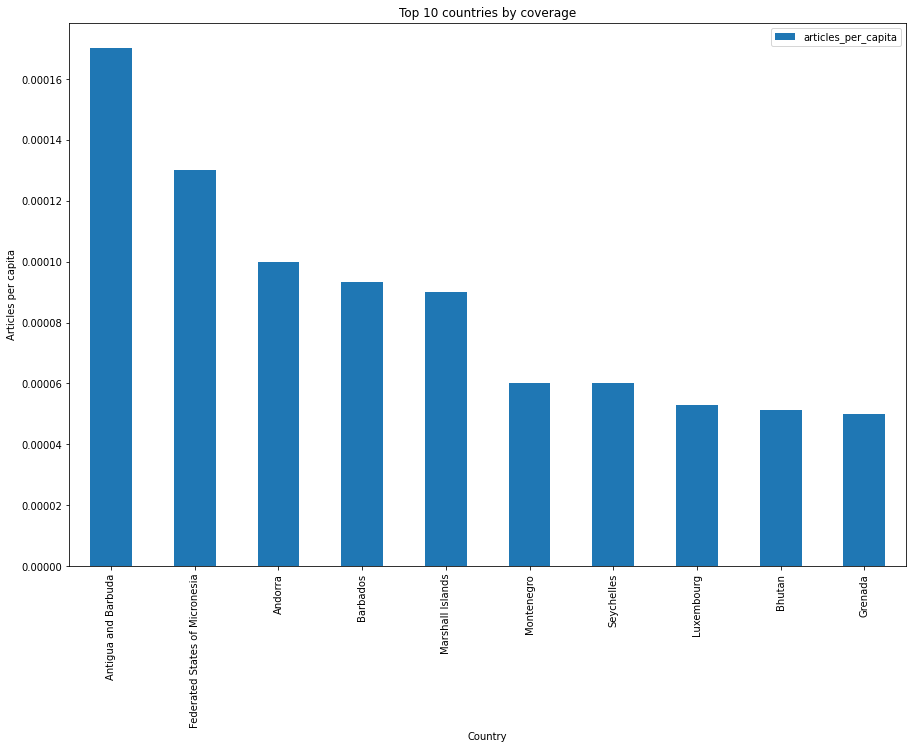

In [24]:
# Construct the bar plot for countries
ax = countries_coverage_top10.plot.bar(x='country', y='articles_per_capita', rot = 90, figsize=(15, 10))
# adding title to the plot
plt.title('Top 10 countries by coverage')
# adding Label to the x-axis and y-axis
plt.xlabel('Country')
plt.ylabel('Articles per capita')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/plots/top10_countries_by_coverage.png')

## Bottom 10 countries by coverage
The 10 countries with the lowest total articles per capita (in ascending order)

In [25]:
countries_coverage_bottom10 = country_total_articles.reindex(index = country_total_articles.index[::-1]).head(10)[['country', 'articles_per_capita']]
countries_coverage_bottom10['country']

177           China
176          Mexico
175    Saudi Arabia
174         Romania
173           India
172       Sri Lanka
171           Egypt
170        Ethiopia
169          Taiwan
168         Vietnam
Name: country, dtype: object

Plot the data for bottom 10 countries by coverage

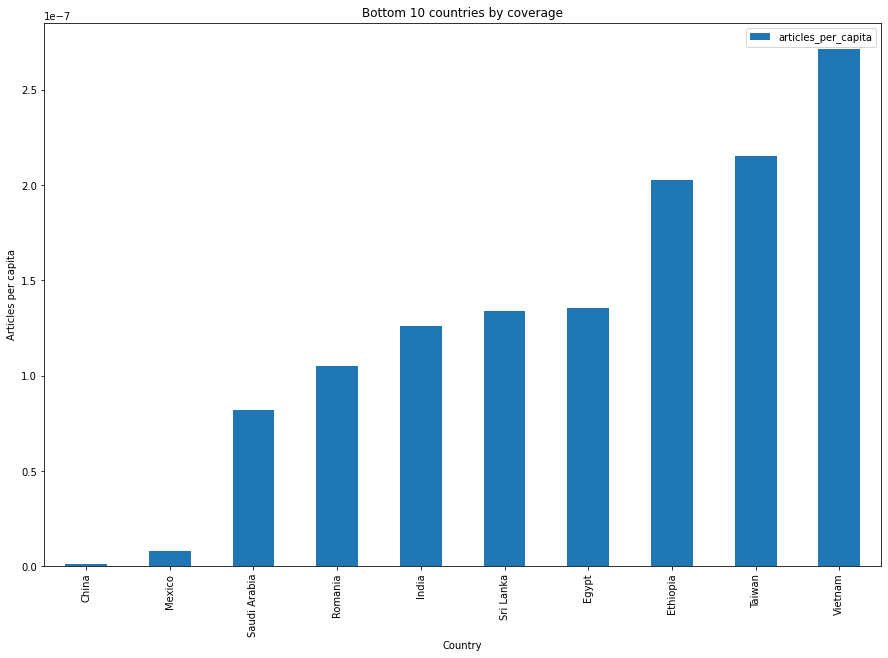

In [26]:
# Construct the bar plot for countries
ax = countries_coverage_bottom10.plot.bar(x='country', y='articles_per_capita', rot = 90, figsize=(15, 10))
# adding title to the plot
plt.title('Bottom 10 countries by coverage')
# adding Label to the x-axis and y-axis
plt.xlabel('Country')
plt.ylabel('Articles per capita')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/plots/bottom10_countries_by_coverage.png')

## Top 10 countries by high quality
The 10 countries with the highest high quality articles per capita (in descending order)

In [27]:
countries_quality_top10 = country_high_quality.head(10)[['country', 'quality_articles_per_capita']]
countries_quality_top10['country']

0               Andorra
1            Montenegro
2                 Spain
3             Lithuania
4    Bosnia-Herzegovina
5               Georgia
6                Panama
7                Norway
8           El Salvador
9              Bulgaria
Name: country, dtype: object

Plot the data for top 10 countries by high quality article per capita

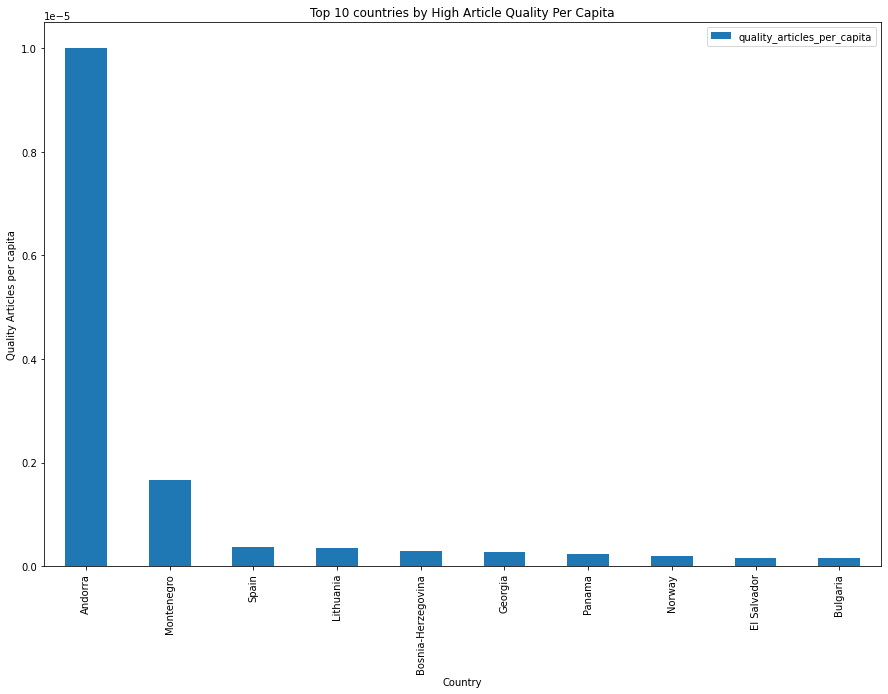

In [28]:
# Construct the bar plot for countries
ax = countries_quality_top10.plot.bar(x='country', y='quality_articles_per_capita', rot = 90, figsize=(15, 10))
# adding title to the plot
plt.title('Top 10 countries by High Article Quality Per Capita')
# adding Label to the x-axis and y-axis
plt.xlabel('Country')
plt.ylabel('Quality Articles per capita')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/plots/top10_countries_by_quality.png')

## Bottom 10 countries by high quality
The 10 countries with the lowest high quality articles per capita (in ascending order)

In [29]:
countries_quality_bottom10 = country_high_quality.reindex(index = country_high_quality.index[::-1]).head(10)[['country', 'quality_articles_per_capita']]
countries_quality_bottom10['country']

24          India
23        Germany
22    Afghanistan
21         Poland
20       Malaysia
19          Syria
18          Chile
17        Romania
16      Guatemala
15           Peru
Name: country, dtype: object

Plot the data for bottom 10 countries by high quality article per capita

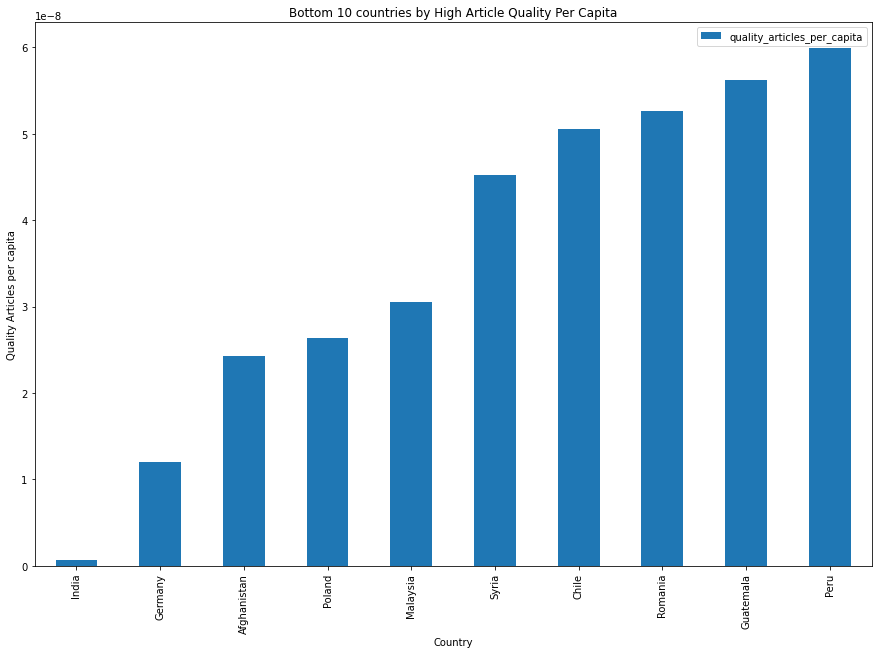

In [30]:
# Construct the bar plot for countries
ax = countries_quality_bottom10.plot.bar(x='country', y='quality_articles_per_capita', rot = 90, figsize=(15, 10))
# adding title to the plot
plt.title('Bottom 10 countries by High Article Quality Per Capita')
# adding Label to the x-axis and y-axis
plt.xlabel('Country')
plt.ylabel('Quality Articles per capita')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/plots/bottom10_countries_by_quality.png')

## Geographic regions by total coverage
A rank ordered list of geographic regions (in descending order) by total articles per capita

In [31]:
region_coverage = region_total_articles[['region', 'articles_per_capita']]
region_coverage['region']

0     SOUTHERN EUROPE
1           CARIBBEAN
2      WESTERN EUROPE
3      EASTERN EUROPE
4     NORTHERN EUROPE
5        WESTERN ASIA
6             OCEANIA
7     SOUTHERN AFRICA
8      EASTERN AFRICA
9       SOUTH AMERICA
10     WESTERN AFRICA
11       CENTRAL ASIA
12    CENTRAL AMERICA
13      MIDDLE AFRICA
14    NORTHERN AFRICA
15     SOUTHEAST ASIA
16         SOUTH ASIA
17          EAST ASIA
Name: region, dtype: object

Plot the data for geogrpahic regions by total article per capita

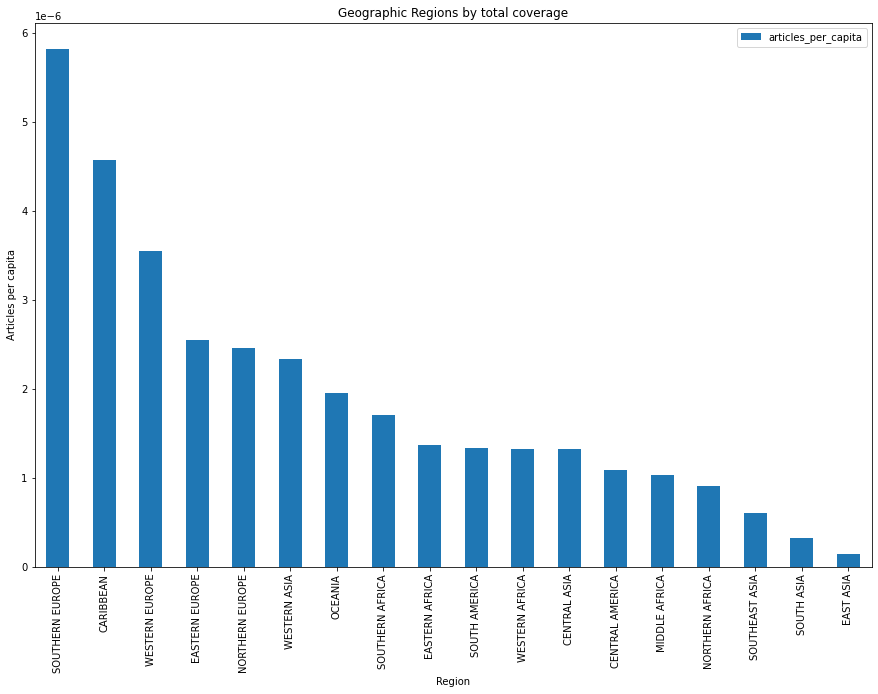

In [32]:
# Construct the bar plot for regions
ax = region_coverage.plot.bar(x='region', y='articles_per_capita', rot = 90, figsize=(15, 10))
# adding title to the plot
plt.title('Geographic Regions by total coverage')
# adding Label to the x-axis and y-axis
plt.xlabel('Region')
plt.ylabel('Articles per capita')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/plots/regions_total_coverage.png')

## Geographic regions by high quality coverage
Rank ordered list of geographic regions (in descending order) by high quality articles per capita

In [33]:
region_quality = region_high_quality[['region', 'quality_articles_per_capita']]
region_quality['region']

0     SOUTHERN EUROPE
1     NORTHERN EUROPE
2     CENTRAL AMERICA
3      EASTERN EUROPE
4       SOUTH AMERICA
5        WESTERN ASIA
6      WESTERN EUROPE
7      WESTERN AFRICA
8     NORTHERN AFRICA
9      EASTERN AFRICA
10         SOUTH ASIA
11     SOUTHEAST ASIA
Name: region, dtype: object

Plot the data for geogrpahic regions by high quality article per capita

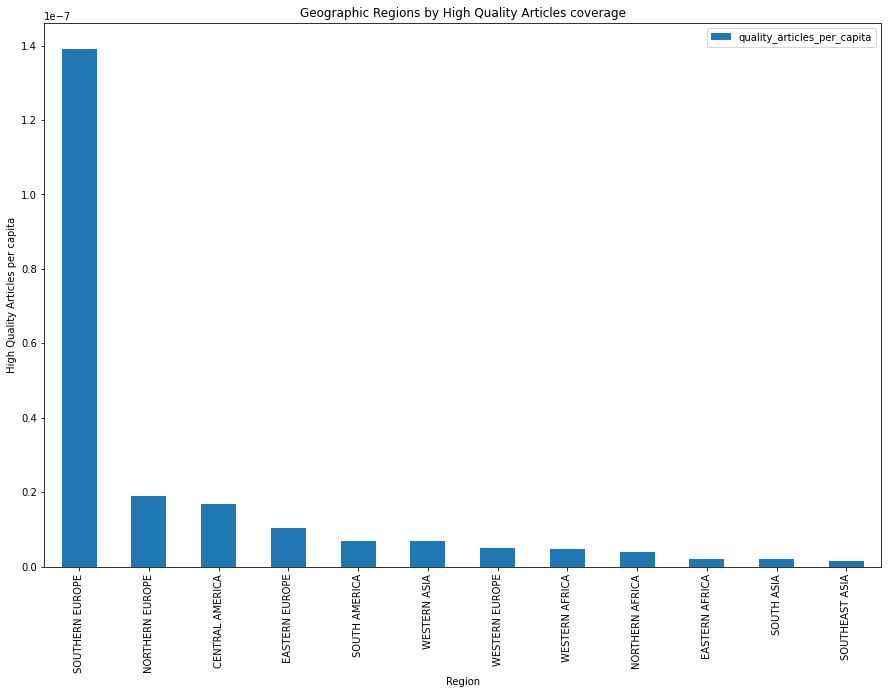

In [34]:
# Construct the bar plot for regions
ax = region_quality.plot.bar(x='region', y='quality_articles_per_capita', rot = 90, figsize=(15, 10))
# adding title to the plot
plt.title('Geographic Regions by High Quality Articles coverage')
# adding Label to the x-axis and y-axis
plt.xlabel('Region')
plt.ylabel('High Quality Articles per capita')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-homework_2/plots/regions_high_quality_coverage.png')